# Indicators of Loan Default
## by Lucrezia Morvilli

## Preliminary Wrangling

> I have decided to analyse one of the datasets in the options, **Prosper Loan Data**. It includes data on 100k+ loans, with extensive information and various details on them. 
> By looking at the Data Dictionary I decided to focus on 12 features of these loans:
> - *ListingNumber*: The number that uniquely identifies the listing to the public as displayed on the website.
- *ListingCreationDate*: The date the listing was created.
- *CreditGrade*: The Credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings.
- *Term*: The length of the loan expressed in months.
- *LoanStatus*: The current status of the loan: Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.
- *ClosedDate*: Closed date is applicable for Cancelled, Completed, Chargedoff and Defaulted loan statuses.
- *ProsperRating (numeric)*: The  Prosper Rating assigned at the time the listing was created (applicable for loans originated after July 2009): 
    -  0 - N/A
    -  1 - HR
    -  2 - E 
    -  3 - D
    -  4 - C 
    -  5 - B 
    -  6 - A 
    -  7 - AA  
- *ProsperScore*: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score.  Applicable for loans originated after July 2009.
- *ListingCategory*: The category of the listing that the borrower selected when posting their listing: 
    -  0 - Not Available 
    -  1 - Debt Consolidation 
    -  2 - Home Improvement 
    -  3 - Business 
    -  4 - Personal Loan 
    -  5 - Student Use 
    -  6 - Auto 
    -  7 - Other 
    -  8 - Baby&Adoption 
    -  9 - Boat 
    -  10 - Cosmetic Procedure 
    -  11 - Engagement Ring 
    -  12 - Green Loans 
    -  13 - Household Expenses 
    -  14 - Large Purchases 
    -  15 - Medical/Dental 
    -  16 - Motorcycle
    -  17 - RV 
    -  18 - Taxes 
    -  19 - Vacation
    -  20 - Wedding Loans
- *Occupation*: The Occupation selected by the Borrower at the time they created the listing.
- *EmploymentStatus*: The employment status of the borrower at the time they posted the listing.
- *IsBorrowerHomeowner*: A Borrower will be classified as a homowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as dates

%matplotlib inline

In [3]:
# load dataset
df = pd.read_csv('prosperLoanData.csv')

df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


> Below I will perform some initial exploratory analysis of the dataset, in order to understand more regarding the type of data it contains.

In [4]:
df.shape

(113937, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

## Cleaning ##
Here I will define the data I will analyse and perform some quick cleaning actions before looking at loan features.

In [6]:
# define df that will be analysed
df_loans = df[['ListingNumber', 'ListingCreationDate', 'CreditGrade', 'Term', 'LoanStatus', 'ClosedDate', 'ProsperRating (numeric)', 'ProsperScore', 'ListingCategory (numeric)', 'Occupation', 'EmploymentStatus', 'IsBorrowerHomeowner']]

In [7]:
df_loans.shape

(113937, 12)

In [8]:
df_loans.Occupation.value_counts()

Other                                 28617
Professional                          13628
Computer Programmer                    4478
Executive                              4311
Teacher                                3759
Administrative Assistant               3688
Analyst                                3602
Sales - Commission                     3446
Accountant/CPA                         3233
Clerical                               3164
Sales - Retail                         2797
Skilled Labor                          2746
Retail Management                      2602
Nurse (RN)                             2489
Construction                           1790
Truck Driver                           1675
Laborer                                1595
Police Officer/Correction Officer      1578
Civil Service                          1457
Engineer - Mechanical                  1406
Military Enlisted                      1272
Food Service Management                1239
Engineer - Electrical           

In [9]:
df_loans.Occupation.nunique()

67

In [10]:
df_loans.EmploymentStatus.value_counts()

Employed         67322
Full-time        26355
Self-employed     6134
Not available     5347
Other             3806
Part-time         1088
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64

In [11]:
df_loans.CreditGrade.value_counts()

C     5649
D     5153
B     4389
AA    3509
HR    3508
A     3315
E     3289
NC     141
Name: CreditGrade, dtype: int64

In [12]:
df_loans['ListingNumber'].duplicated().sum()

871

In [13]:
#checking one duplicate listing
df_loans[df_loans['ListingNumber']==1023355]

,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,IsBorrowerHomeowner
8,1023355,2013-12-02 10:43:39.117000000,NaN,36,Current,NaN,7.0,9.0,7,Food Service,Employed,True
9,1023355,2013-12-02 10:43:39.117000000,NaN,36,Current,NaN,7.0,11.0,7,Food Service,Employed,True


In [14]:
df_loans[df_loans['ProsperScore']>10]

,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,IsBorrowerHomeowner
9,1023355,2013-12-02 10:43:39.117000000,NaN,36,Current,NaN,7.0,11.0,7,Food Service,Employed,True
69,1162592,2014-01-25 12:07:54.537000000,NaN,60,Current,NaN,6.0,11.0,1,Investor,Self-employed,True
158,1202850,2014-02-12 16:31:25.340000000,NaN,36,Current,NaN,7.0,11.0,6,Tradesman - Mechanic,Employed,False
224,1130508,2014-01-10 07:24:44.853000000,NaN,36,Current,NaN,6.0,11.0,1,Sales - Commission,Employed,True
236,973657,2013-11-02 01:29:09.810000000,NaN,36,Current,NaN,7.0,11.0,1,Tradesman - Mechanic,Employed,True
277,1220331,2014-02-18 12:59:08.680000000,NaN,60,Current,NaN,5.0,11.0,1,Other,Full-time,False
476,1244304,2014-03-06 08:54:42.840000000,NaN,60,Current,NaN,5.0,11.0,1,Other,Employed,False
491,1116282,2014-01-06 07:18:54.173000000,NaN,60,Current,NaN,5.0,11.0,1,Analyst,Employed,True
532,1150992,2014-01-20 10:51:29.120000000,NaN,36,Current,NaN,6.0,11.0,1,NaN,Other,True
554,1054630,2013-12-17 22:15:59.470000000,NaN,60,Current,NaN,7.0,11.0,7,Other,Employed,True


> From the Data Dictionary we know that the *Prosper Score* should range from 1 to 10. We should check that this is true in the data and delete the lines with *Prosper Score* above 10 (as we have enough data anyway). We will also check that *Prosper Rating* and *Listing Category* have valid values.

In [15]:
list_drop = df_loans[df_loans['ProsperScore']>10]['ListingNumber'].index.tolist()

for t in list_drop:
    df_loans= df_loans.drop(t)

In [16]:
df_loans = df_loans.reset_index(drop = True)
df_loans.shape

(112481, 12)

In [17]:
#remove the listings for which we have neither Credit Grade nor Prosper Rating
list_drop_credit = df_loans[(df_loans['CreditGrade'].isnull())&(df_loans['ProsperRating (numeric)'].isnull())].index.tolist()
for t in list_drop_credit:
    df_loans= df_loans.drop(t)

In [18]:
df_loans = df_loans.reset_index(drop = True)
df_loans.shape

(112350, 12)

In [19]:
df_loans['ListingCategory (numeric)'].value_counts()

1     57302
0     16965
7     10374
2      7268
3      7079
6      2531
4      2395
13     1967
15     1493
18      868
14      857
20      755
19      754
5       750
16      303
11      212
8       191
10       91
9        85
12       59
17       51
Name: ListingCategory (numeric), dtype: int64

In [20]:
df_loans['ProsperRating (numeric)'].value_counts()

4.0    18320
5.0    15410
3.0    14274
6.0    14030
2.0     9795
1.0     6935
7.0     4633
Name: ProsperRating (numeric), dtype: int64

The values for *Listing Category* and *Prosper Rating* are all valid. 

In [21]:
#is there any null listing?
df_loans.ListingNumber.isnull().sum()

0

In [22]:
#look at the remaining duplicate values
df_loans.sort_values(['ListingNumber'], inplace=True)
df_loans.ListingNumber.duplicated().sum()

823

In [23]:
df_loans[df_loans['ListingNumber']==786407]

,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,IsBorrowerHomeowner
16108,786407,2013-05-22 19:42:23.417000000,NaN,60,Current,NaN,3.0,6.0,1,Other,Other,False
86007,786407,2013-05-22 19:42:23.417000000,NaN,60,Current,NaN,3.0,4.0,1,Other,Other,False


> As in the duplicate above, it's hard to tell which of the two lines should be kept. Given that the listings having this issue are less than 1% of our dataset, we will move on and focus on the big picture by exploring the data visually. 

In [24]:
#shape of final dataset
df_loans.shape

(112350, 12)

### What is the structure of your dataset?

> The dataset is made of 112481 rows and 12 columns. It's a subset of the original ProsperLoanData dataset as we want to focus on fewer variables. We have also dropped a few rows containing an invalid value for the Prosper Score and rows having N/A for both Prosper Rating and Credit Grade.

### What is/are the main feature(s) of interest in your dataset?

> I kept the variables I was more interested in, thinking of what I would want to analyse:
- Time of the loan: when and for how long the loan was open 
- Credit rating/score: risk scores assigned to each loan
- Loan features: category, status
- Characteristics of the borrowers: are they home owner, what is their employment status and occupation
> My aim would be to find at least one insight in each of the four categories through visualisation.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Thanks to the large amount of data and the use of visualisation techniques for analysis, I will try to gather insights on the features mentioned above and the relationships among them. The variables I will use are the following:
> - General: 
    - ListingNumber
- Time of the loan:
    - ListingCreationDate
    - Term
    - ClosedDate   
- Credit Rating/Score:
    - Credit Grade  
    - ProsperRating (numeric)
    - ProsperScore
- Loan features:
    - LoanStatus
    - ListingCategory   
- Borrowers' features:
    - Occupation
    - EmploymentStatus
    - IsBorrowerHomeowner

## Univariate Exploration

> Here we will look at each individual variable separately.

## Loan term ##
### Listing Creation Date ###

In [25]:
#change data format to datetime
df_loans['ListingCreationDate'] = pd.to_datetime(df_loans['ListingCreationDate'])

#create groupby object to get the number of listings each month
df_1 = pd.DataFrame(df_loans.set_index('ListingCreationDate').groupby(pd.Grouper(freq='M'))['ListingNumber'].count().reset_index())

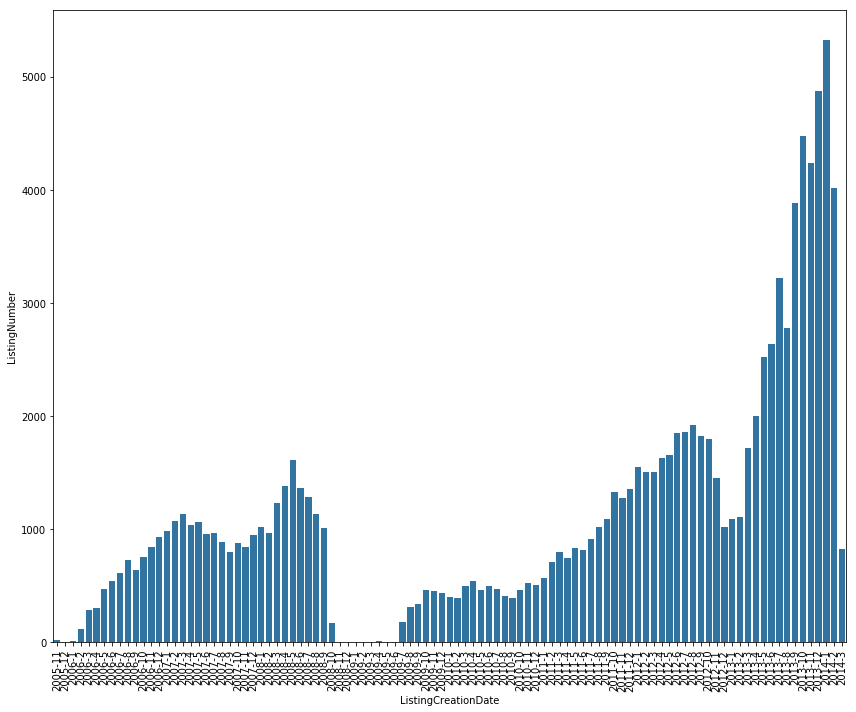

In [26]:
base = sb.color_palette()[0]
total = df_loans.shape[0]
fig=plt.figure(figsize=(12, 10))

sb.barplot(x="ListingCreationDate", y="ListingNumber", data=df_1, color = base)
plt.xticks(plt.xticks()[0], (df_1.ListingCreationDate.dt.year.astype(str))+"-"+(df_1.ListingCreationDate.dt.month.astype(str)), rotation=90)
plt.tight_layout()
plt.show()

> We can see that there is an increasing trend from the end of 2005 to the beginning of 2014: more loans were created in the  last period of the dataset rather than in the initial one. 
It's also interesting to note that between end of 2008 and end of 2009, which coincides with the period of the financial crisis, almost no new loans were created.

### Term ###

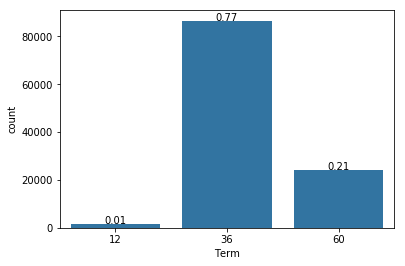

In [27]:
ax_term = sb.countplot(data = df_loans, x = 'Term', color = base)
for p in ax_term.patches:
    height = p.get_height()
    ax_term.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show();

> Most of the loans (77%) have a 3-year term, 21% have a 5-year term and only 1% are for a year.

### Closed Date ###

In [28]:
#same as for the ListingCreationDate
df_loans['ClosedDate'] = pd.to_datetime(df_loans['ClosedDate'])
df_2 = pd.DataFrame(df_loans.set_index('ClosedDate').groupby(pd.Grouper(freq='M'))['ListingNumber'].count().reset_index())

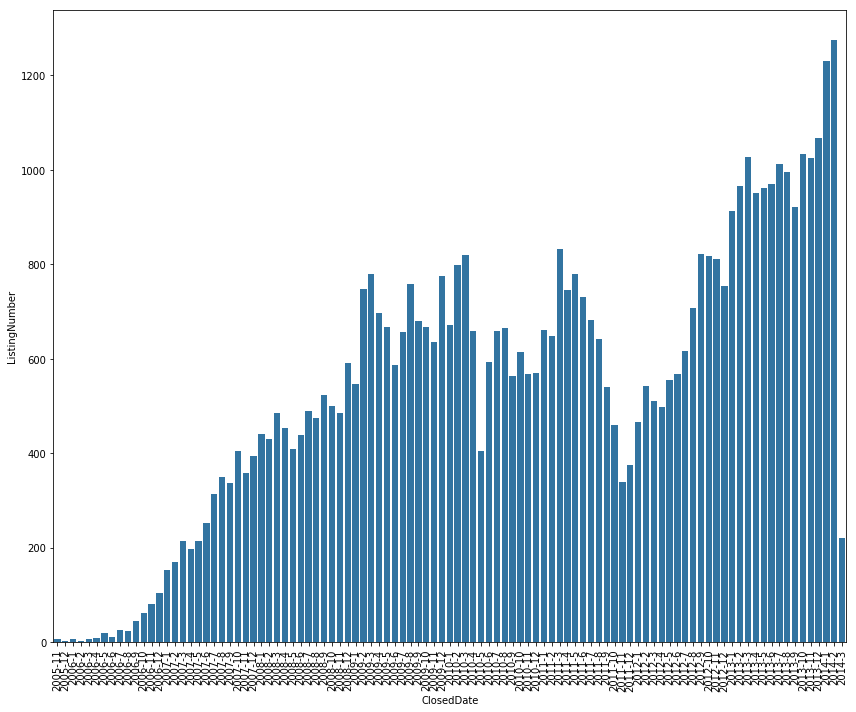

In [29]:
fig=plt.figure(figsize=(12, 10))

sb.barplot(x="ClosedDate", y="ListingNumber", data=df_2, color = base)
plt.xticks(plt.xticks()[0], (df_2.ClosedDate.dt.year.astype(str))+"-"+(df_2.ClosedDate.dt.month.astype(str)), rotation=90)
plt.tight_layout()
plt.show()

> Here as well we see an increasing trend of number of closed loans. We will create a new variable to look at the distribution of the length of the loans, ie for how long loans were open. 

### Duration ###

In [30]:
df_loans['Duration'] = (df_loans['ClosedDate'] - df_loans['ListingCreationDate']).abs().dt.components.days

In [31]:
df_loans['months'] = round(df_loans.Duration/30,0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


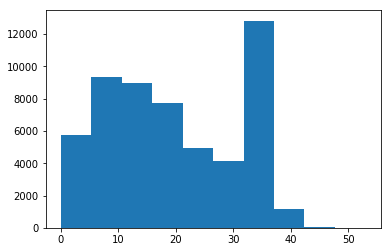

In [32]:
plt.hist(data = df_loans, x = 'months');

> We have a bimodal distribution of the loan duration, with peaks at 1 year and 3 years. At a later stage we could compare this with loan status and loan term.

## Credit Rating ##
### Credit Grade ###
This variable was used for loans pre-2009.

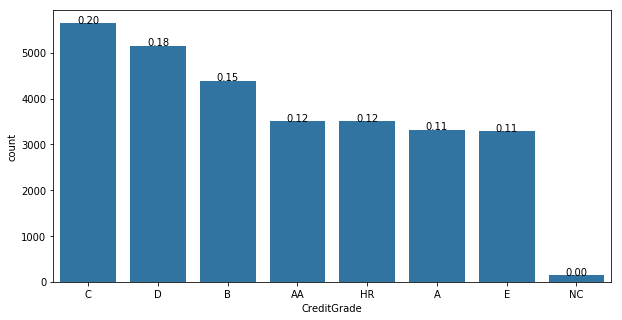

In [33]:
total_credit = df_loans.CreditGrade.notnull().sum()

order_credit = df_loans.CreditGrade.value_counts().index.tolist()

fig = plt.figure(figsize = (10,5))

ax_credit = sb.countplot(data = df_loans, x = 'CreditGrade', color = base, order = order_credit)

for p in ax_credit.patches:
    height = p.get_height()
    ax_credit.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total_credit),
            ha="center") 
plt.show();

> Most of the data is in the middle range ie B-C-D, with fewer loans having very high or very low credit grades. 

### Prosper Rating ###
A measure used after July 2009.

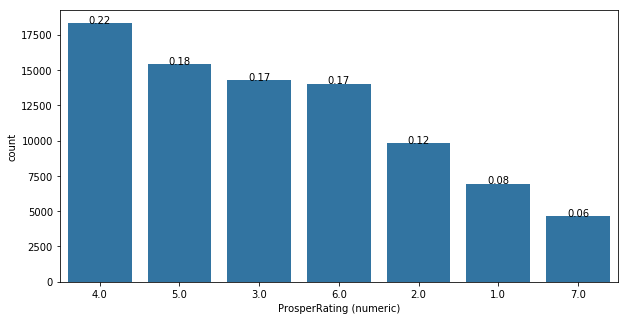

In [34]:
total_rating = df_loans['ProsperRating (numeric)'].notnull().sum()

order_rating = df_loans['ProsperRating (numeric)'].value_counts().index.tolist()

fig = plt.figure(figsize = (10,5))

ax_rating = sb.countplot(data = df_loans, x = 'ProsperRating (numeric)', color = base, order = order_rating)

for p in ax_rating.patches:
    height = p.get_height()
    ax_rating.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total_rating),
            ha="center") 
plt.show();

> As we noticed earlier, credit ratings after 2009 (called *Prosper Ratings*) are mainly concentrated in the middle ranges rather than the extreme ones, ie we have fewer loans with rating 1, 2 or 7.

### Prosper Score ###
A measure used after July 2009.

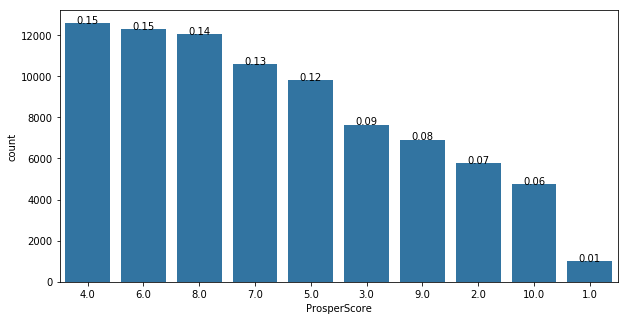

In [35]:
total_grade = df_loans['ProsperScore'].notnull().sum()

order_grade = df_loans['ProsperScore'].value_counts().index.tolist()

fig = plt.figure(figsize = (10,5))

ax_grade = sb.countplot(data = df_loans, x = 'ProsperScore', color = base, order = order_grade)

for p in ax_grade.patches:
    height = p.get_height()
    ax_grade.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total_grade),
            ha="center") 
plt.show();

> This measure as well, which is a custom risk score built by using Prosper historical data, shows concentration in the middle range ie between 4 and 8.

## Loan features ##
### Loan Status ###

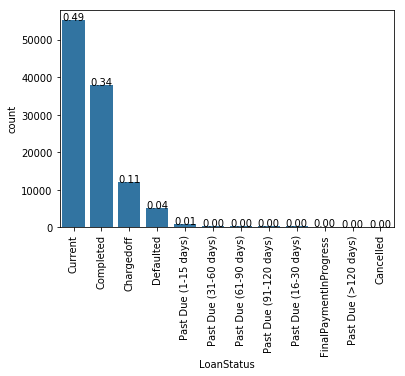

In [36]:
order_status = df_loans.LoanStatus.value_counts().index.tolist()

ax = sb.countplot(data = df_loans, x = 'LoanStatus', color = base, order = order_status)
plt.xticks(rotation=90)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show();

> From here we can see that less than 2% of the loans are Past Due, around 4% defaulted and 11% got charged off. With the help of other variables we will be able to get more details on the duration and term of outstanding loans and completed ones. 

### Listing Category ###

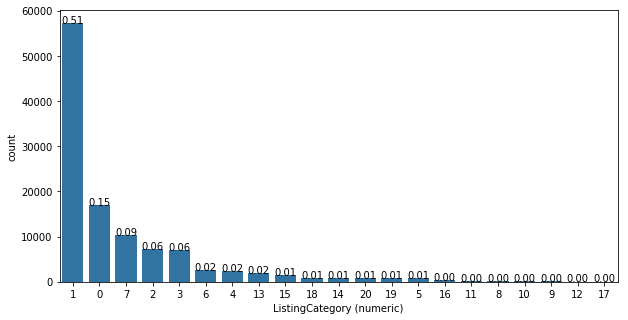

In [37]:
order_listing = df_loans['ListingCategory (numeric)'].value_counts().index.tolist()

fig = plt.figure(figsize = (10,5))

ax_listing = sb.countplot(data = df_loans, x = 'ListingCategory (numeric)', color = base, order = order_listing)
for p in ax_listing.patches:
    height = p.get_height()
    ax_listing.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show();

> This distribution gives us some interesting insights on the population:
- Roughly half of the borrowers asked a loan for Debt Consolidation
- 25% either did not give a reason or falls into the "Other" loan category
- 6% needed money for Home Improvement
- 6% for Business

## Borrowers' features ##
### Employment Status ###

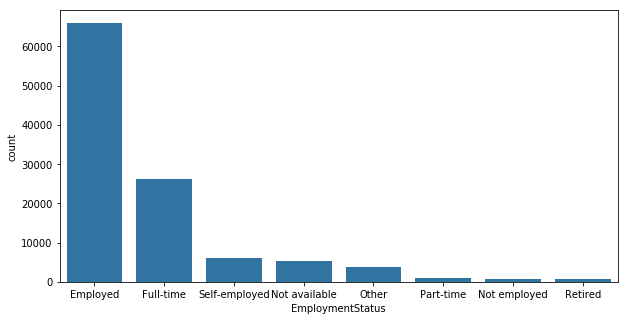

In [38]:
order_employment = df_loans.EmploymentStatus.value_counts().index.tolist()
fig = plt.figure(figsize = (10,5))
sb.countplot(data = df_loans, x = 'EmploymentStatus', color = base, order = order_employment);

> The classification of the employment status is not consistent as we have labels such as Employed, Full-time and Part-time, when full-time and part-time are subsets of "employed". We can still gather from this chart that most of the loans were given to employed people. The percentage of non-employed, other or retired people is quite low (less than 5%). The fact that the majority of loans is given to employed people was expected. 

### Is Borrower HomeOwner? ###

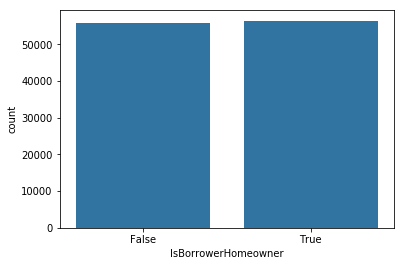

In [39]:
sb.countplot(data = df_loans, x = 'IsBorrowerHomeowner', color = base);

> It looks like our data is split almost 50-50 between homeowners and not. 

### Occupation ###

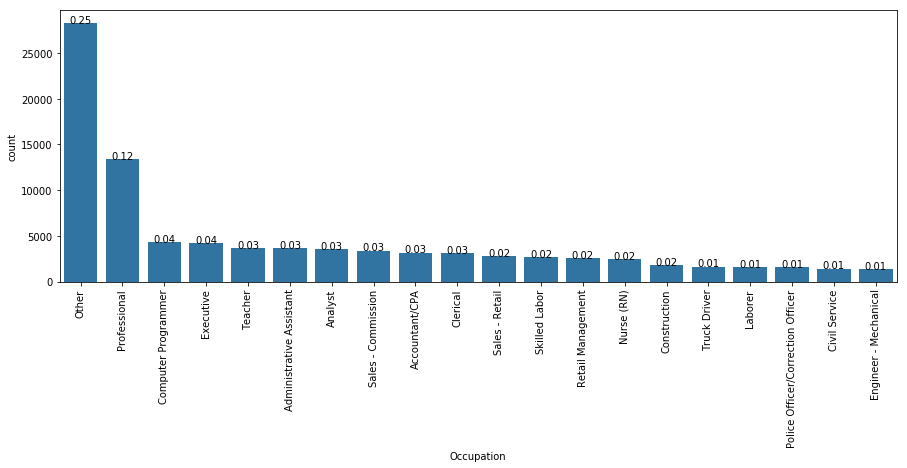

In [40]:
#top 20 occupations
order_occupation = df_loans.Occupation.value_counts().index.tolist()[:20]
fig = plt.figure(figsize = (15,5))

ax_1 = sb.countplot(data = df_loans, x = 'Occupation', color = base, order = order_occupation)
plt.xticks(rotation=90)
for p in ax_1.patches:
    height = p.get_height()
    ax_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center");

> Occupation might be the least useful/easy variable to analyse. There are many unique occupations in the dataset (almost 70) and most of the loans were given to "Other" and "Professional" workers, which doesn't give enough details on the type of profession. 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Initially, I cleaned the data to remove some unusual points (for instance the rows Prosper Scores above 10). During the univariate analysis, I had to change the data format of some columns to be able to plot it.
> Also, in order to find out the duration of each loan I had to create a new variable that takes the closing date and subtracts from it the creation date. This returned the number of days between the two dates, which I then transformed in months for convenience. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> The univariate distributions are all generally as expected, with some interesting insights that we will investigate further in the next step. 
- Term of the loan:
    - The more recent years have seen an increasing trend in number of loans being **created** and **closed**.
    - Most of the loans have a 3 year **term**.
    - The **duration** of the loans follows a bimodal distribution with peaks at the 1 year and 3 years points. 
- Credit Rating/Score:
    - By looking at the Credit Grade, Prosper Rating and Prosper Score, we found out that most of the borrowers have a **credit score** lying in the middle, ie the credit score roughly follows a normal distribution. 
- Loan features:
    - Most of the loans are current or completed, with only a very small portion being with **status** past due, defaulted or charged off. 
    - Among the **reasons** for which loans have been taken out, the most common are: Debt Consolidation, Home improvement, Business. A quarter of the reasons were classified as "Other". 
- Borrower's features:
    - As expected, most of the borrowers (ca 95%) are **employed**.
    - An interesting fact is that the population is split in half between borrowers **owning a house** and not owning a house.
    - The borrower's **occupation** is not detailed enough for most of the population, we can therefore avoid analysing this variable in the next stage.  

## Bivariate Exploration

> In this section, we will investigate relationships between pairs of variables. I would like to get some further insights mainly on:
- the relationship between credit rating and other variables
- the variables that give a higher likelihood of defaulted/charged off loans
 
### 1) Loan Status vs Score
> Let's see if there is a relationship between defaulting on a loan or getting the loan charged off and the Prosper Score. 

In [41]:
df_status = df_loans[df_loans.LoanStatus.notnull()]

#store totals per Prosper Score and Loan Status
df_score_status = pd.DataFrame(df_status.groupby(['ProsperScore', 'LoanStatus'])['ListingNumber'].count()).reset_index()

#store totals per Prosper Score
df_score_aggregate = pd.DataFrame(df_score_status.groupby('ProsperScore')['ListingNumber'].sum())

In [42]:
#merge
df_score_status = df_score_status.merge(df_score_aggregate, on = 'ProsperScore', how = 'left')

In [43]:
#get proportions
df_score_status['Proportion'] = df_score_status['ListingNumber_x']/df_score_status['ListingNumber_y']

#for visual
df_score_status_visual = df_score_status[df_score_status['LoanStatus'].isin(['Chargedoff', 'Defaulted'])]

In [44]:
df_score_status_visual

,ProsperScore,LoanStatus,ListingNumber_x,ListingNumber_y,Proportion
0,1.0,Chargedoff,235,992,0.236895
3,1.0,Defaulted,37,992,0.037298
10,2.0,Chargedoff,377,5766,0.065383
13,2.0,Defaulted,70,5766,0.012140
21,3.0,Chargedoff,414,7642,0.054174
24,3.0,Defaulted,75,7642,0.009814
32,4.0,Chargedoff,784,12595,0.062247
35,4.0,Defaulted,119,12595,0.009448
43,5.0,Chargedoff,907,9813,0.092428
46,5.0,Defaulted,165,9813,0.016814


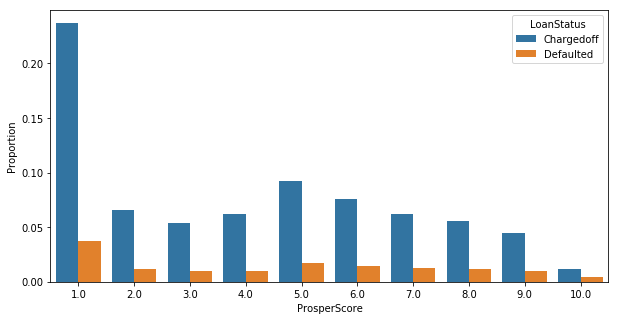

In [45]:
fig = plt.figure(figsize = (10,5))

sb.barplot(data = df_score_status_visual, x = 'ProsperScore', y = 'Proportion', hue = 'LoanStatus');

> This is telling us that more than 20% of the borrowers with a Prosper score of 1 have their loan charged off and almost 5% defaulted. These percentages go decreasing and are the lowest for borrowers with credit score equal to 10, which shows that the two features are correlated and people with a lower Prosper score tend to have a higher chance to have their loans charge off or default.  

### 2) Loan Status vs Credit Grade/Prosper Rating
> We will now perform a similar analysis, looking at the relationship between the amount of charged off/defaulted loans and credit rating.

In [46]:
df_creditGrade = df_loans[df_loans.CreditGrade.notnull()]
df_creditGrade = df_creditGrade[df_creditGrade.LoanStatus.notnull()]

#store totals per Credit Grade and Loan Status
df_grade_status = pd.DataFrame(df_creditGrade.groupby(['CreditGrade', 'LoanStatus'])['ListingNumber'].count()).reset_index()

#store totals per Credit Grade
df_grade_aggregate = pd.DataFrame(df_grade_status.groupby('CreditGrade')['ListingNumber'].sum())

In [47]:
#merge
df_grade_status = df_grade_status.merge(df_grade_aggregate, on = 'CreditGrade', how = 'left')

In [48]:
#get proportions
df_grade_status['Proportion'] = df_grade_status['ListingNumber_x']/df_grade_status['ListingNumber_y']

#for visual
df_grade_status_visual = df_grade_status[df_grade_status['LoanStatus'].isin(['Chargedoff', 'Defaulted'])]

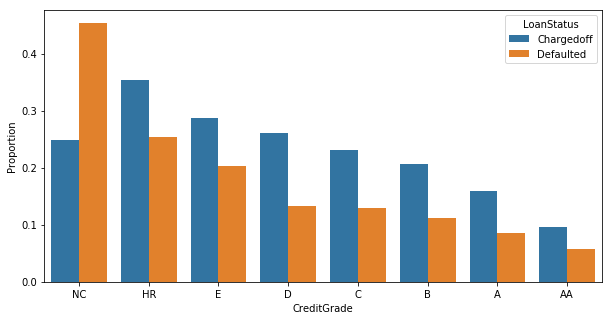

In [49]:
fig = plt.figure(figsize = (10,5))
order_creditGrade = ['NC', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA']

sb.barplot(data = df_grade_status_visual, x = 'CreditGrade', y = 'Proportion', hue = 'LoanStatus', order = order_creditGrade);

In [50]:
df_prosperRating = df_loans[df_loans['ProsperRating (numeric)'].notnull()]
df_prosperRating = df_prosperRating[df_prosperRating.LoanStatus.notnull()]

#store totals per Prosper Rating and Loan Status
df_rating_status = pd.DataFrame(df_prosperRating.groupby(['ProsperRating (numeric)', 'LoanStatus'])['ListingNumber'].count()).reset_index()

#store totals per Prosper Rating
df_rating_aggregate = pd.DataFrame(df_rating_status.groupby('ProsperRating (numeric)')['ListingNumber'].sum())

#merge
df_rating_status = df_rating_status.merge(df_rating_aggregate, on = 'ProsperRating (numeric)', how = 'left')

In [51]:
#get proportions
df_rating_status['Proportion'] = df_rating_status['ListingNumber_x']/df_rating_status['ListingNumber_y']

#for visual
df_rating_status_visual = df_rating_status[df_rating_status['LoanStatus'].isin(['Chargedoff', 'Defaulted'])]

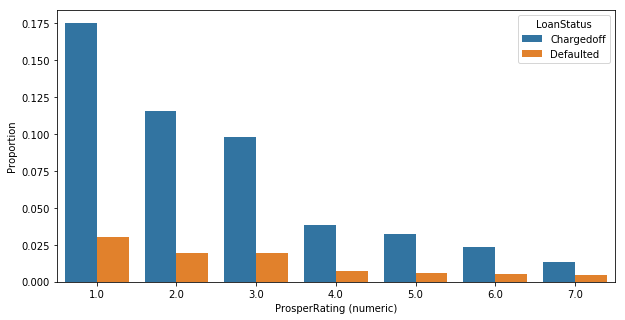

In [52]:
fig = plt.figure(figsize = (10,5))

sb.barplot(data = df_rating_status_visual, x = 'ProsperRating (numeric)', y = 'Proportion', hue = 'LoanStatus');

> A similar trend can be seen here, ie a higher credit grade or Prosper rating implies a lower amount of chargedoff and defaulted loans.
> This shows that the rating allocated by Prosper is quite useful in determining the likelihood of loan default. 

### 3) Prosper Score vs Prosper Rating
> We can guess that there is high correlation between Prosper Score and Prosper Rating but we can double-check this. Credit Grade might have had a high correlation with Prosper Score as well, however Prosper Score has been introduced as a measure when Prosper Rating was introduced.  

In [53]:
df_score_rating = df_prosperRating[df_prosperRating.ProsperScore.notnull()]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


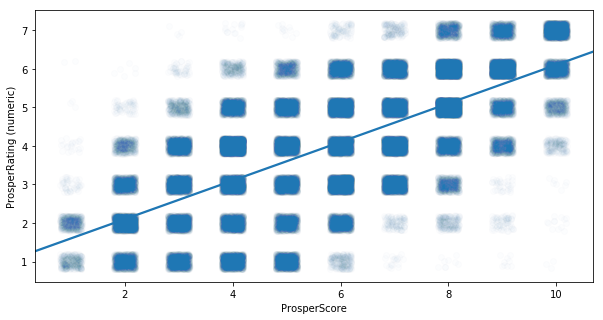

In [54]:
fig = plt.figure(figsize = (10,5))

sb.regplot(data = df_score_rating, x = 'ProsperScore', y = 'ProsperRating (numeric)', x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/100});

> There is a positive linear relationship between Prosper Score and Prosper Rating, ie a higher score leads to a higher rating. Therefore, we can check the relationship between other features and either one of Prosper Score/Prosper Rating interchangeably for the rest of our exploratory analysis and for the data after 2009.

### 4) Homeowner vs Prosper Rating/Credit Grade
> Next, we will assess the relationship between being a homeowner and Prosper Rating/CreditGrade. For easiness we will create a variable called rating that picks up either Credit Grade or Prosper Rating. 

In [55]:
# check that there aren't listings for which both are N/A
df_loans[(df_loans.CreditGrade.isnull())&(df_loans['ProsperRating (numeric)'].isnull())]

,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,IsBorrowerHomeowner,Duration,months


In [56]:
# check that there aren't listings for which both are populated
df_loans[(df_loans.CreditGrade.notnull())&(df_loans['ProsperRating (numeric)'].notnull())]

,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,IsBorrowerHomeowner,Duration,months


In [57]:
#create Rating column that gets populated with either credit grade or prosper rating
df_loans['Rating'] = ''

m1 = df_loans['CreditGrade'].notnull()
m2 = df_loans['ProsperRating (numeric)'].notnull()

df_loans['Rating'] = df_loans['Rating'].mask(m1, df_loans['CreditGrade']).mask(m2, df_loans['ProsperRating (numeric)'])

In [58]:
#store totals per Rating and Homeowner status
df_rating_home = pd.DataFrame(df_loans.groupby(['Rating', 'IsBorrowerHomeowner'])['ListingNumber'].count()).reset_index()

#store totals per Rating
df_home_aggregate = pd.DataFrame(df_rating_home.groupby('Rating')['ListingNumber'].sum())

#merge
df_rating_home = df_rating_home.merge(df_home_aggregate, on = 'Rating', how = 'left')

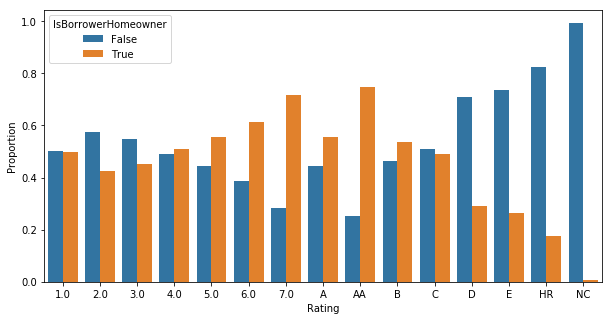

In [59]:
#get proportions
df_rating_home['Proportion'] = df_rating_home['ListingNumber_x']/df_rating_home['ListingNumber_y']

fig = plt.figure(figsize = (10,5))

sb.barplot(data = df_rating_home, x = 'Rating', y = 'Proportion', hue = 'IsBorrowerHomeowner');

> We can see a peak of homeowners in the centre, where rating is AA/A or 6/7, decreasing with lower credit ratings. The opposite trend can be observed for non homeowners.  

### 5) Homeowner vs Loan Status
> Do homeowners tend to default or have loans charged off less often?

In [60]:
default_off = df_loans[df_loans.LoanStatus.isin(['Chargedoff', 'Defaulted'])]

In [61]:
default_off.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 74792 to 106807
Data columns (total 15 columns):
ListingNumber                17000 non-null int64
ListingCreationDate          17000 non-null datetime64[ns]
CreditGrade                  10660 non-null object
Term                         17000 non-null int64
LoanStatus                   17000 non-null object
ClosedDate                   17000 non-null datetime64[ns]
ProsperRating (numeric)      6340 non-null float64
ProsperScore                 6340 non-null float64
ListingCategory (numeric)    17000 non-null int64
Occupation                   16187 non-null object
EmploymentStatus             16187 non-null object
IsBorrowerHomeowner          17000 non-null bool
Duration                     17000 non-null float64
months                       17000 non-null float64
Rating                       17000 non-null object
dtypes: bool(1), datetime64[ns](2), float64(4), int64(3), object(5)
memory usage: 2.0+ MB


In [62]:
default_off.groupby('IsBorrowerHomeowner').count()

,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,Duration,months,Rating
IsBorrowerHomeowner,,,,,,,,,,,,,,
False,9400,9400,5998,9400,9400,9400,3402,3402,9400,8793,8793,9400,9400,9400
True,7600,7600,4662,7600,7600,7600,2938,2938,7600,7394,7394,7600,7600,7600


In [63]:
9400/17000

0.5529411764705883

In [64]:
df_loans.IsBorrowerHomeowner.value_counts()

True     56440
False    55910
Name: IsBorrowerHomeowner, dtype: int64

In [65]:
55910/(55910+56440)

0.4976412995104584

> While in the full dataset we have that 49.8% of the borrowers are not homeowners, when we look at the population of charged off and defaulted loans, 55.3% do not own a house, indicating there might be some correlation between these two variables. 

### 6) Duration vs Term
> We have calculated the duration in months for the completed loans, as we do not have a closed date for Current or Past Due loans. We now want to check the performance between duration and originally set term of loans that are completed. 

In [66]:
df_duration = df_loans[df_loans['months'].notnull()]

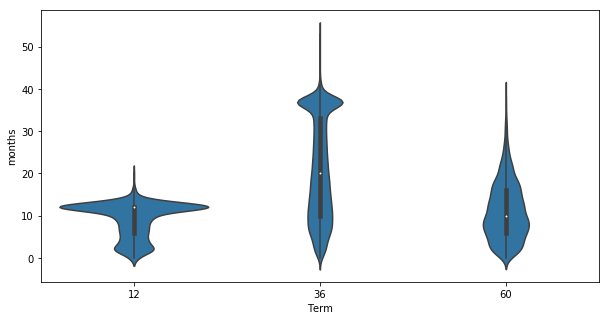

In [67]:
fig = plt.figure(figsize = (10,5))
sb.violinplot(data = df_duration, x = 'Term', y = 'months', color = base);

In [68]:
df_loans.groupby(['Term', 'LoanStatus']).count()['ListingNumber']

Term  LoanStatus            
12    Chargedoff                   72
      Completed                  1449
      Current                      62
      Defaulted                    10
      FinalPaymentInProgress       10
      Past Due (1-15 days)          3
      Past Due (16-30 days)         3
      Past Due (31-60 days)         1
      Past Due (61-90 days)         2
      Past Due (91-120 days)        1
36    Cancelled                     5
      Chargedoff                10828
      Completed                 34058
      Current                   35362
      Defaulted                  4818
      FinalPaymentInProgress      155
      Past Due (1-15 days)        553
      Past Due (16-30 days)       174
      Past Due (31-60 days)       239
      Past Due (61-90 days)       205
      Past Due (91-120 days)      193
      Past Due (>120 days)          9
60    Chargedoff                 1086
      Completed                  2414
      Current                   19733
      Defaulted      

In [69]:
df_loans[df_loans['Term']==60]['ListingCreationDate'].min()

Timestamp('2010-07-02 02:01:21.567000')

In [70]:
df_loans['ListingCreationDate'].max()

Timestamp('2014-03-10 12:20:53.760000')

> A very interesting insight can be gathered here: most of the loans with term of 12 or 36 months were kept across the whole duration, whereas the ones with a term of 5 years were repaid earlier. It's also true that we do not have much data as most of the loans with a term of 60 months are still active. The first of these loans was created in 2010 and the dataset gets to 2014. 

### 7) Duration vs Loan Status
> Let's look at the term distribution of charged off and defaulted loans.

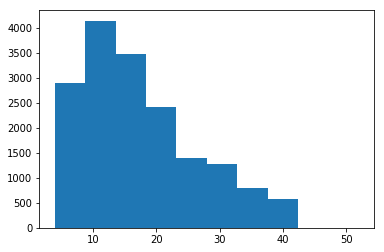

In [71]:
plt.hist(data = default_off, x = 'months'); #right-skewed distribution

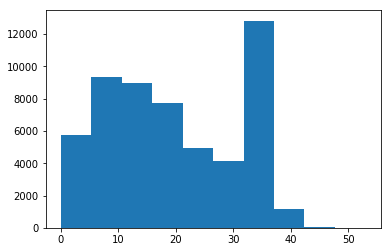

In [72]:
#on the whole dataset for comparison
plt.hist(data = df_loans, x = 'months');

> We can see the peak is in 1Y duration rather than 3Y as in the full dataset. We will look now at the term. 

### 8) Term vs Loan Status

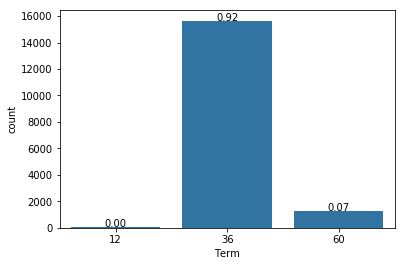

In [73]:
total_default_off = default_off.shape[0]

ax_default_off = sb.countplot(data = default_off, x = 'Term', color = base)

for p in ax_default_off.patches:
    height = p.get_height()
    ax_default_off.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total_default_off),
            ha="center");

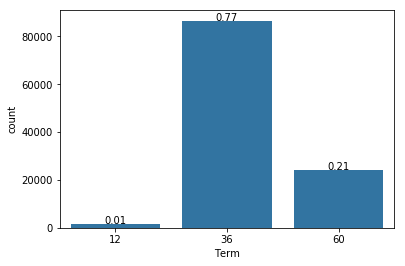

In [74]:
#on the whole dataset for comparison
ax = sb.countplot(data = df_loans, x = 'Term', color= base)
total = df_loans.shape[0]

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center");

> Let's look at whether the creation or closed date can be an indicator of default.

In [75]:
default_year_create = pd.DataFrame(default_off.set_index('ListingCreationDate').groupby(pd.Grouper(freq='Y'))['ListingNumber'].count().reset_index())
default_year_create['Proportion'] = default_year_create['ListingNumber']/total_default_off

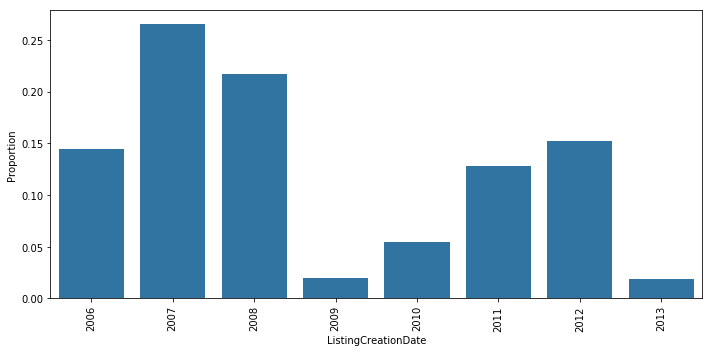

In [76]:
fig = plt.figure(figsize = (10,5))

sb.barplot(data = default_year_create, x = 'ListingCreationDate', y= 'Proportion', color = base)
plt.xticks(plt.xticks()[0], (default_year_create.ListingCreationDate.dt.year.astype(str)), rotation=90)
plt.tight_layout();

In [77]:
create = pd.DataFrame(df_loans.set_index('ListingCreationDate').groupby(pd.Grouper(freq='Y'))['ListingNumber'].count().reset_index())
create['Proportion'] = create['ListingNumber']/total

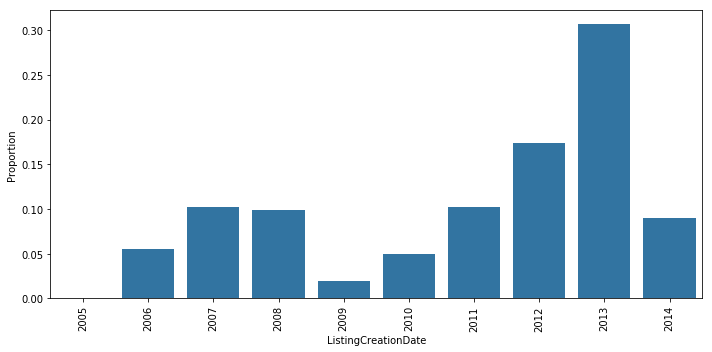

In [78]:
fig = plt.figure(figsize = (10,5))

sb.barplot(data = create, x = 'ListingCreationDate', y= 'Proportion', color = base)

plt.xticks(plt.xticks()[0], (create.ListingCreationDate.dt.year.astype(str)), rotation=90)
plt.tight_layout();

In [79]:
default_year_close = pd.DataFrame(default_off.set_index('ClosedDate').groupby(pd.Grouper(freq='Y'))['ListingNumber'].count().reset_index())
default_year_close['Proportion'] = default_year_close['ListingNumber']/total_default_off

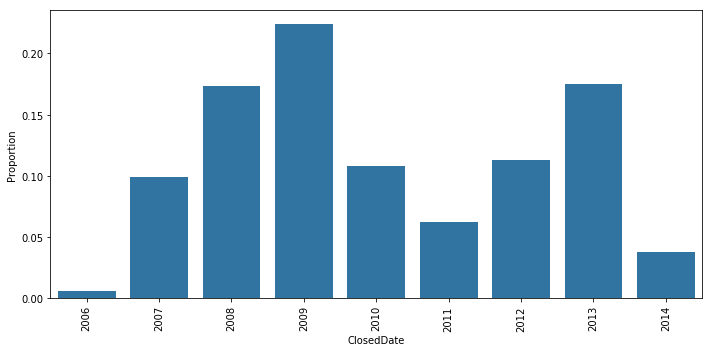

In [80]:
fig = plt.figure(figsize = (10,5))

sb.barplot(data = default_year_close, x = 'ClosedDate', y= 'Proportion', color = base)
plt.xticks(plt.xticks()[0], (default_year_close.ClosedDate.dt.year.astype(str)), rotation=90)
plt.tight_layout();

In [81]:
close = pd.DataFrame(df_loans.set_index('ClosedDate').groupby(pd.Grouper(freq='Y'))['ListingNumber'].count().reset_index())
close['Proportion'] = close['ListingNumber']/total

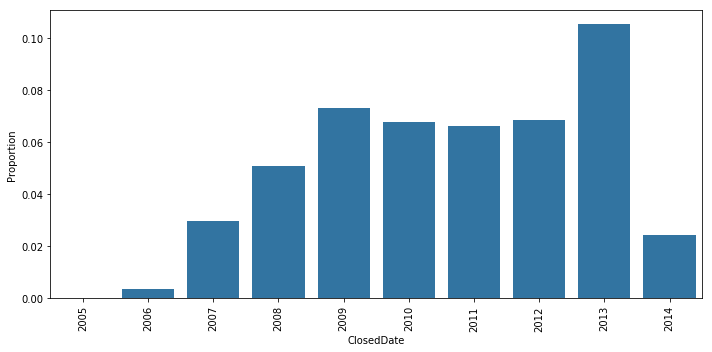

In [82]:
fig = plt.figure(figsize = (10,5))

sb.barplot(data = close, x = 'ClosedDate', y= 'Proportion', color = base)
plt.xticks(plt.xticks()[0], (close.ClosedDate.dt.year.astype(str)), rotation=90)
plt.tight_layout();

> The loans that defaulted or got charged off have a higher percentage of 3Y contractual term, compared to the full population. 
> A super interesting insight came from looking at the creation and closed date of the loans: a great majority of the defaulted and charged off loans were closed in 2008 and 2009. 

### 9) Term vs Category

In [83]:
df_loans.isnull().sum()

ListingNumber                    0
ListingCreationDate              0
CreditGrade                  83397
Term                             0
LoanStatus                       0
ClosedDate                   57424
ProsperRating (numeric)      28953
ProsperScore                 28953
ListingCategory (numeric)        0
Occupation                    3568
EmploymentStatus              2255
IsBorrowerHomeowner              0
Duration                     57424
months                       57424
Rating                           0
dtype: int64

In [84]:
#store totals per Category and Term
df_category = pd.DataFrame(df_loans.groupby(['ListingCategory (numeric)', 'Term'])['ListingNumber'].count()).reset_index()

#store totals per Category
category_aggregate = pd.DataFrame(df_category.groupby('ListingCategory (numeric)')['ListingNumber'].sum())

#merge
df_category = df_category.merge(category_aggregate, on = 'ListingCategory (numeric)', how = 'left')

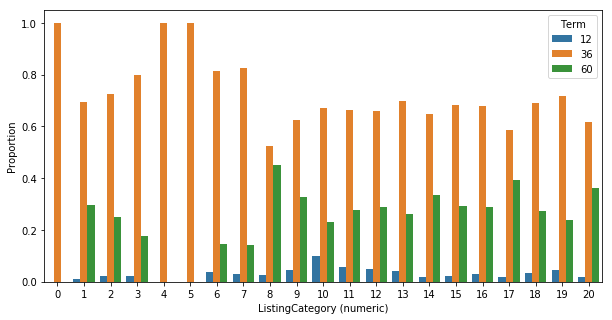

In [85]:
#get proportions
df_category['Proportion'] = df_category['ListingNumber_x']/df_category['ListingNumber_y']

fig = plt.figure(figsize = (10,5))

sb.barplot(data = df_category, x = 'ListingCategory (numeric)', y = 'Proportion', hue = 'Term');

> For each of the category we have that the higher percentage comes from 3Y loans. For category 8 (Baby and Adoption), the proportion of 5Y loans get closer to the one of 3Y loans. Let's now look at the highest category for each term, ie we look at the relation between these two variables the other way round. 

In [86]:
df_12 = df_loans[df_loans.Term == 12]
df_36 = df_loans[df_loans.Term == 36]
df_60 = df_loans[df_loans.Term == 60]

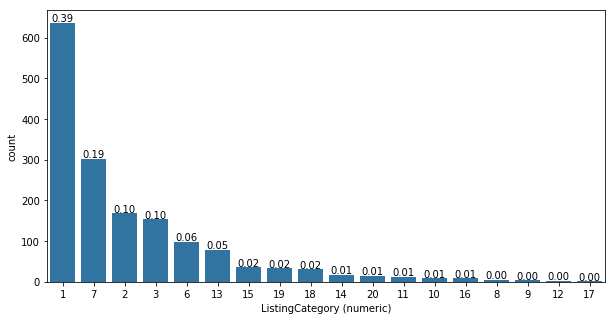

In [87]:
fig = plt.figure(figsize = (10,5))
order_12 = df_12['ListingCategory (numeric)'].value_counts().index.tolist()
total_12 = df_12.shape[0]

ax_12 = sb.countplot(data = df_12, x = 'ListingCategory (numeric)', color = base, order = order_12)

for p in ax_12.patches:
    height = p.get_height()
    ax_12.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_12),
            ha="center") 
plt.show();

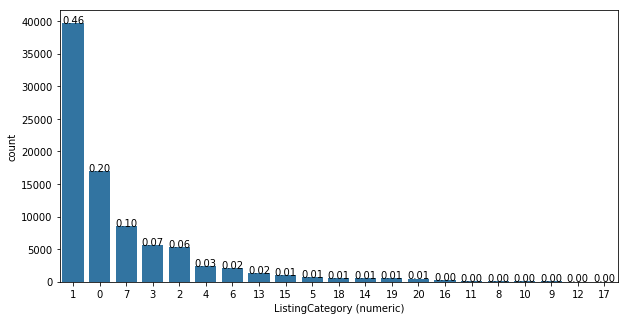

In [88]:
fig = plt.figure(figsize = (10,5))
order_36 = df_36['ListingCategory (numeric)'].value_counts().index.tolist()
total_36 = df_36.shape[0]

ax_36 = sb.countplot(data = df_36, x = 'ListingCategory (numeric)', color = base, order = order_36)

for p in ax_36.patches:
    height = p.get_height()
    ax_36.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_36),
            ha="center") 
plt.show();

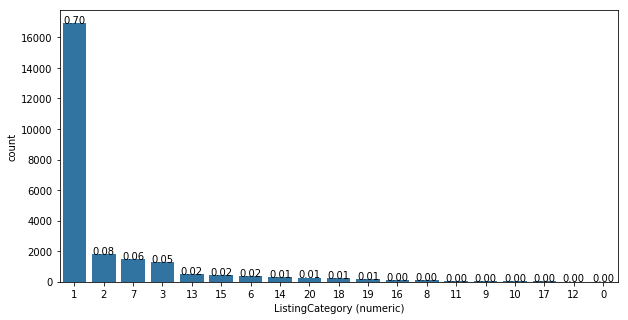

In [89]:
fig = plt.figure(figsize = (10,5))
order_60 = df_60['ListingCategory (numeric)'].value_counts().index.tolist()
total_60 = df_60.shape[0]

ax_60 = sb.countplot(data = df_60, x = 'ListingCategory (numeric)', color = base, order = order_60)

for p in ax_60.patches:
    height = p.get_height()
    ax_60.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_60),
            ha="center") 
plt.show();

> Here we note that higher the term, higher is the proportion of loans for Debt Consolidation.

### 10) Term vs Rating
> Do borrowers with higher credit rating get a loan with higher term?

In [90]:
df_term_rating = pd.DataFrame(df_loans.groupby(['Rating', 'Term']).count()['ListingNumber']).reset_index()
df_term_rating['Proportion'] = df_term_rating['ListingNumber']/112350

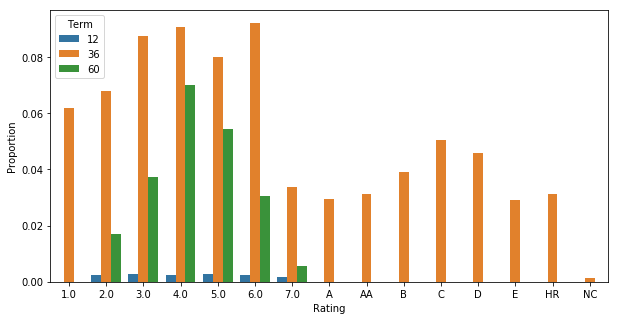

In [91]:
fig = plt.figure(figsize = (10,5))

sb.barplot(data = df_term_rating, x = 'Rating', y = 'Proportion', hue = 'Term');

> Only 3Y loans seem to be present before 2009, so let's focus on the period after 2009 and at the Prosper score.

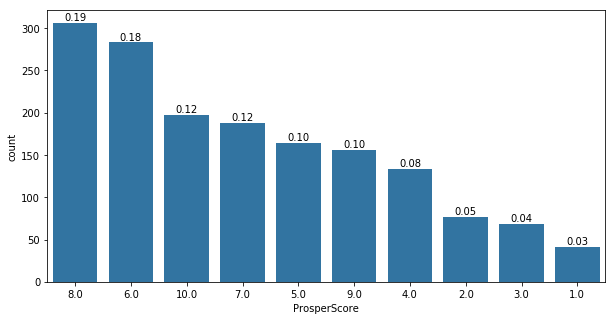

In [92]:
fig = plt.figure(figsize = (10,5))
order_12 = df_12['ProsperScore'].value_counts().index.tolist()
total_12 = df_12.ProsperScore.value_counts().sum()

ax_12 = sb.countplot(data = df_12, x = 'ProsperScore', color = base, order = order_12)

for p in ax_12.patches:
    height = p.get_height()
    ax_12.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_12),
            ha="center") 
plt.show();

In [93]:
0.19*8+0.18*6+10*0.12+0.12*7+5*0.1+9*0.1+4*0.08+2*0.05+3*0.04+1*0.03

6.61

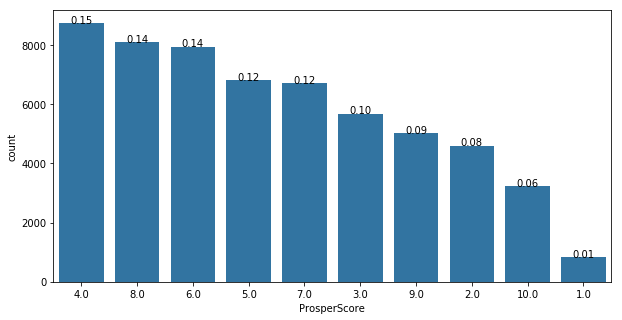

In [94]:
fig = plt.figure(figsize = (10,5))
order_36 = df_36['ProsperScore'].value_counts().index.tolist()
total_36 = df_36.ProsperScore.value_counts().sum()

ax_36 = sb.countplot(data = df_36, x = 'ProsperScore', color = base, order = order_36)

for p in ax_36.patches:
    height = p.get_height()
    ax_36.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_36),
            ha="center") 
plt.show();

In [95]:
4*0.15+8*0.14+0.14*6+0.12*5+0.12*7+0.1*3+0.09*9+2*0.08 +10*0.06 + 0.01*1

5.88

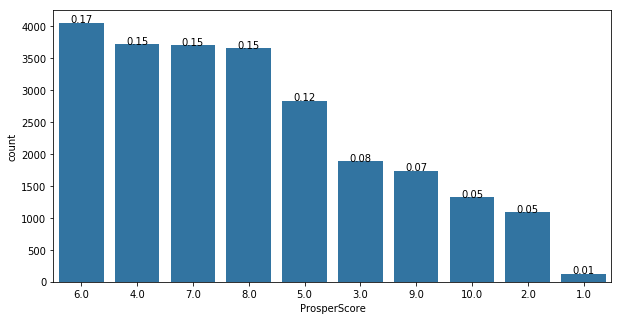

In [96]:
fig = plt.figure(figsize = (10,5))
order_60 = df_60['ProsperScore'].value_counts().index.tolist()
total_60 = df_60.ProsperScore.value_counts().sum()

ax_60 = sb.countplot(data = df_60, x = 'ProsperScore', color = base, order = order_60)

for p in ax_60.patches:
    height = p.get_height()
    ax_60.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_60),
            ha="center") 
plt.show();

In [97]:
6*0.17+4*0.15+0.15*7+0.15*8+0.12*5+3*0.08+9*0.07+10*0.05+2*0.05+1*0.01

5.949999999999999

> Unfortunately, I cannot derive any insights from here as it seems that 1Y loans have a higher rating but 5Y loans have higher rating than 3Y loans. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> We considered credit rating as one of the main features in the analysis. This varied in accordance to common sense and expectations. Some of the insights below: 
   - Prosper Score and Prosper Rating are highly correlated variables.
   - People with a lower Prosper score or Credit Rating tend to have a higher chance to have their loans charge off or default. This also tells us that the rating is a good and useful indicator for Prosper, which is always good news!
   -  There is a peak of homeowners where rating is AA/A or 6/7 and the amount is decreasing with lower credit ratings. 
   - There is a smaller proportion of homeowners in the sample of defaulted and charged off loans, compared to the full population.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> One other feature of interest was the duration of the loans. **Before 2009, only 3Y loans were offered**, which obviously makes the analysis by loan term more complex. Also, a lot of defaulted/charged off loans were closed in 2009. 
> 
> Among the completed loans, ie excluding current and past due, generally speaking **1Y and 3Y loans lasted the whole term**, whereas **5Y loans were completed earlier**. 
>
> However, this might due to the fact that the first 5Y loan was created in 2010 and the dataset is until 2014 so we would **need data for the following years** as well to make conclusions on whether 5Y loans get repaid earlier or not. 
>
> Another interesting insight is that, even though the most common loan categories remain the same across the different loan terms, higher the term, **higher is the proportion of loans for Debt Consolidation**.

## Multivariate Exploration

> Here we look at Loan Status, mainly Defaulted and Charged Off loans, term and duration (ie closed date - creation date).

### Difference between Term and Duration


In [98]:
df_loans['TimeDiff'] = df_loans['Term']- df_loans['months']

def new_column(x):
    if x<-12:
        return "Closed >1Y after term date"
    if x <0 and x>=-12:
        return "Closed <1Y after term date"
    elif x>=0 and x<=12:
        return "Closed <1Y before term date"
    elif x>12 and x<25:
        return "Closed 1Y-2Y before term date"
    elif x>24 and x<37:
        return "Closed 2Y-3Y before term date"
    elif x>36 and x<49:
        return "Closed 3Y-4Y before term date"
    elif x>48 and x<61:
        return "Closed 4Y-5Y before term date"
    
df_loans['TimeDiff_Cat'] = df_loans['TimeDiff'].apply(lambda t:new_column(t))

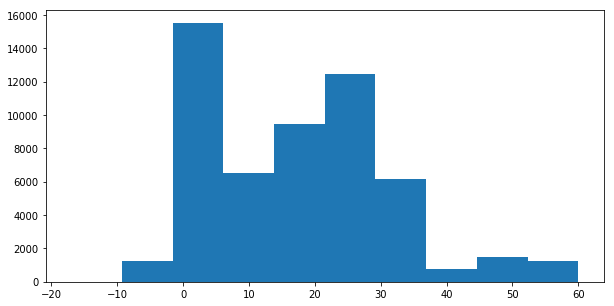

In [99]:
fig = plt.figure(figsize = (10,5))
plt.hist(data = df_loans, x = 'TimeDiff');

In [100]:
default_off_cat = df_loans[df_loans['LoanStatus'].isin(['Chargedoff', 'Defaulted'])]
total_default_off = default_off_cat[default_off_cat['TimeDiff_Cat'].notnull()]['ListingNumber'].count()

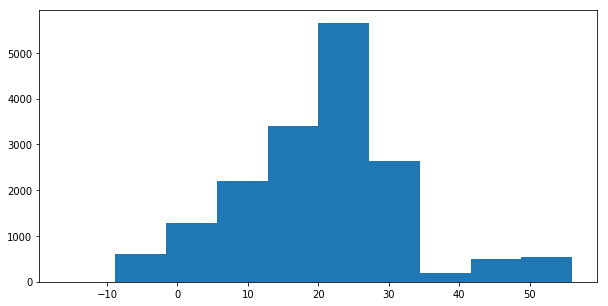

In [101]:
fig = plt.figure(figsize = (10,5))
plt.hist(data=default_off_cat, x = 'TimeDiff'); 

> While loans in general seem to be closed according to the original term, charged off and defaulted loans are generally closed earlier, but let's take a closer look. 

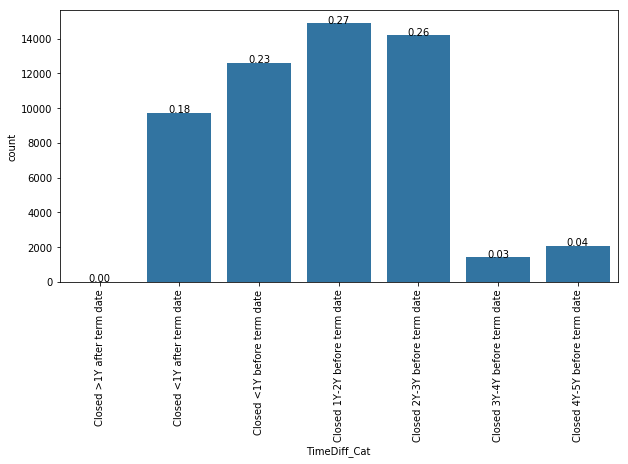

In [102]:
total = df_loans[df_loans['TimeDiff_Cat'].notnull()]['ListingNumber'].count()
order_time = ["Closed >1Y after term date", 'Closed <1Y after term date', 'Closed <1Y before term date', 'Closed 1Y-2Y before term date', "Closed 2Y-3Y before term date", "Closed 3Y-4Y before term date", "Closed 4Y-5Y before term date"]

fig = plt.figure(figsize = (10,5))
time = sb.countplot(data = df_loans, x = 'TimeDiff_Cat', color = base, order = order_time)
plt.xticks(rotation=90)

for p in time.patches:
    height = p.get_height()
    time.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total),
            ha="center");

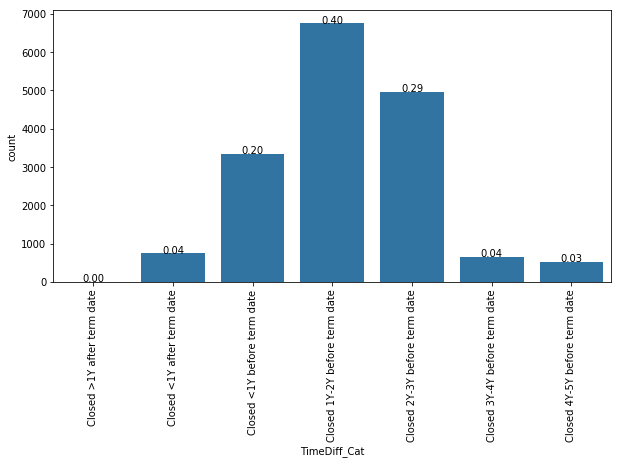

In [103]:
fig = plt.figure(figsize = (10,5))
time_off = sb.countplot(data = default_off_cat, x = 'TimeDiff_Cat', color = base, order = order_time)
plt.xticks(rotation=90)

for p in time_off.patches:
    height = p.get_height()
    time_off.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_default_off),
            ha="center");

> As most of the loans are 3Y let's focus on those.

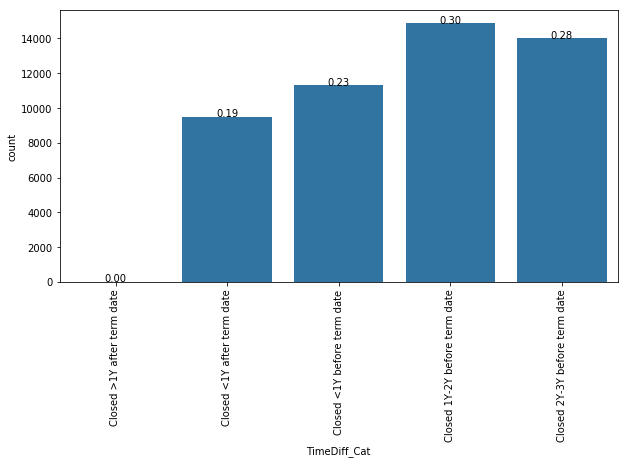

In [104]:
df_loans_3 = df_loans[df_loans['Term']==36]
total_3 = df_loans_3[df_loans_3['TimeDiff_Cat'].notnull()]['ListingNumber'].count()
order_time_3 = ["Closed >1Y after term date", 'Closed <1Y after term date', 'Closed <1Y before term date', 'Closed 1Y-2Y before term date', "Closed 2Y-3Y before term date"]

fig = plt.figure(figsize = (10,5))
time_3 = sb.countplot(data = df_loans_3, x = 'TimeDiff_Cat', color = base, order = order_time_3)
plt.xticks(rotation=90)

for p in time_3.patches:
    height = p.get_height()
    time_3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_3),
            ha="center");

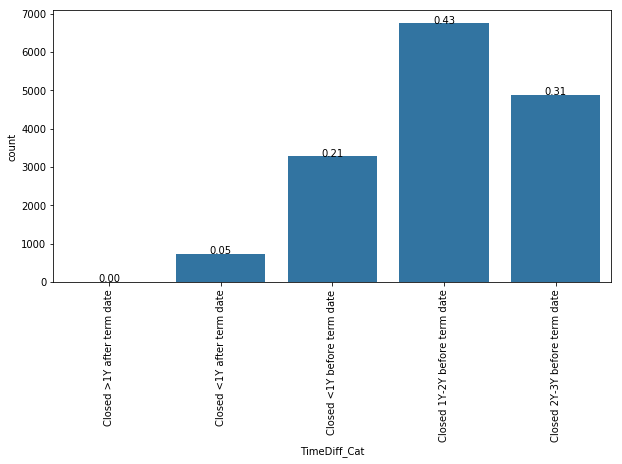

In [105]:
default_off_3 = default_off_cat[default_off_cat['Term']==36]
total_default_off_3 = default_off_3[default_off_3['TimeDiff_Cat'].notnull()]['ListingNumber'].count()
order_time_3 = ["Closed >1Y after term date", 'Closed <1Y after term date', 'Closed <1Y before term date', 'Closed 1Y-2Y before term date', "Closed 2Y-3Y before term date"]

fig = plt.figure(figsize = (10,5))
time_off_3 = sb.countplot(data = default_off_3, x = 'TimeDiff_Cat', color = base, order = order_time_3)
plt.xticks(rotation=90)

for p in time_off_3.patches:
    height = p.get_height()
    time_off_3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:0.2f}'.format(height/total_default_off_3),
            ha="center");

> Various insights can be drawn from the above:
- 18% of the overall population of loans is closed after the term final date whereas this is true for 4% of the defaulted/ charged off loans. This is a sign that loans that are meant to default get identified generally earlier than the final date, which is a good thing for Prosper
- If we look at 3Y loans only, these values become 19% for the overall population and 5% for the defaulted/charged off ones
- 31% of the 3Y loans meant to default or be charged off are closed in the first year. This shows that for almost a third of the loans that ended up being charged off or defaulted, signs of financial distress could be seen quite soon, maybe even at the first due payments. 43% were closed between 1 and 2 years before term date and both percentages are higher than the ones for the overall population. 

### Credit Rating vs Homeowner vs Loan Status
> Here we investigate the relationship between credit rating, being a homeowner and charged off/defaulted loans.

In [106]:
default_off.shape

(17000, 15)

In [107]:
df_loans.LoanStatus.value_counts()

Current                   55157
Completed                 37921
Chargedoff                11986
Defaulted                  5014
Past Due (1-15 days)        805
Past Due (31-60 days)       363
Past Due (61-90 days)       312
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      202
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

In [142]:
df_loans['Rating'] = df_loans.Rating.astype(str)
multi = pd.DataFrame(default_off.groupby(['IsBorrowerHomeowner', 'Rating'])['ListingNumber'].count()).reset_index()
multi['Rating'] = multi['Rating'].astype(str)

In [143]:
multi_aggr = pd.DataFrame(df_loans.groupby('Rating')['ListingNumber'].count()).reset_index()

In [144]:
multi_visual = multi.merge(multi_aggr, on = 'Rating', how = 'left')

In [145]:
multi_visual['Proportion'] = multi_visual['ListingNumber_x']/multi_visual['ListingNumber_y']

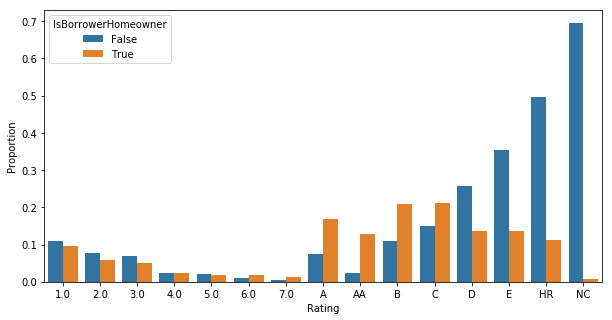

In [146]:
fig = plt.figure(figsize = (10,5))

score_home_final = sb.barplot(data = multi_visual, x = 'Rating', y = 'Proportion', hue = 'IsBorrowerHomeowner')

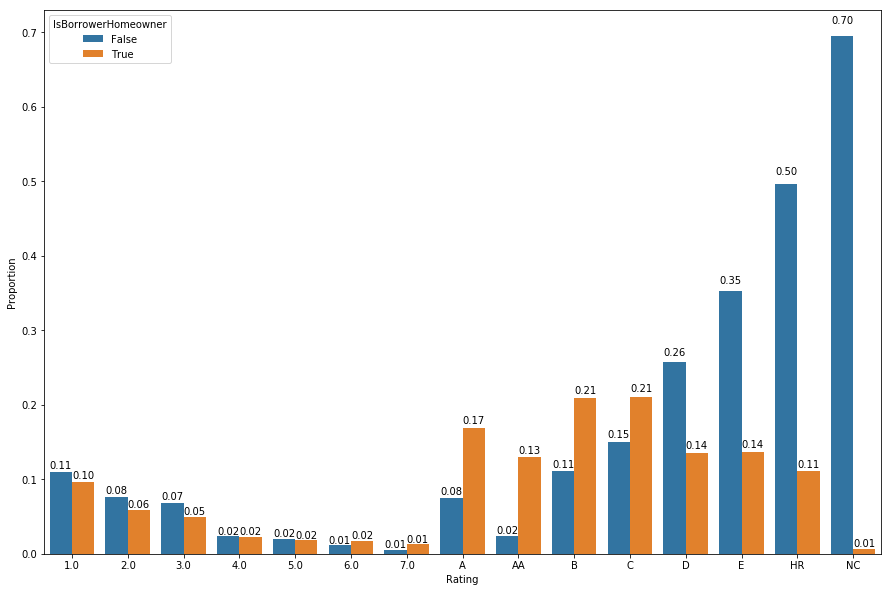

In [147]:
fig = plt.figure(figsize = (15,10))

score_home_final = sb.barplot(data = multi_visual, x = 'Rating', y = 'Proportion', hue = 'IsBorrowerHomeowner')

for rect in score_home_final.patches:
        height = rect.get_height()
        score_home_final.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '{:0.2f}'.format(height),
                ha='center', va='bottom')

In [115]:
df_loans.to_csv('main.csv')

In [116]:
default_off.to_csv('default.csv')

> If we look at the first proportion (11%), this shows that 11% of the borrowers with rating equal to 1 are non-homeowners and defaulted or got loans charged off. 
>
> Around 50% of the high risk borrowers are non-homeowners that defaulted or got their loans charged off. In total, 61% of the HR borrowers, either homeowners or not, are in this interest group. 
>
> As a general trend, we can note that lower rating means a higher proportion of defaulted or charged off loans (21% of the loans with rating equal to 1 and 40% of the loans with rating equal to D defaulted or got charged off). 
>
> Also, generally speaking non-homeowners defaulted more than others as we can see their predominance apart from the very high ratings where there is a much higher percentage of homeowners.
>
> In summary, it seems that owning a home and credit rating are good indicators of likelihood of default.


### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

>  During the last phase of this exploratory analysis, it became obvious that owning a home and credit rating are good indicators of loan default (or writing off). For instance, 61% of the HR loans defaulted/ got charged off and the majority of these were non-homeowners.

### Were there any interesting or surprising interactions between features?

> I expected defaulted/ charged off loans to be closed mostly after the final term date. However, 18% of the overall population of loans is closed after the term final date whereas this is true for only 4% of the defaulted/ charged off loans. This is a sign that loans that are meant to default get identified generally earlier than the final date, which is a good thing for Prosper.